In [1]:
import pandas as pd
import nltk
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt

In [2]:
# Ruta al archivo Parquet
ruta_archivo_parquet = r'C:\Users\guard\OneDrive\Desktop\Henry Data Science\Proyecto-FInal\Datos\df_pizza_NJNY_rev202502110804.parquet'

# Leer el archivo Parquet en un DataFrame
df = pd.read_parquet(ruta_archivo_parquet)

# Mostrar las columnas disponibles
print("Columnas disponibles en el DataFrame:")
print(df.columns)

# Mostrar las primeras filas del DataFrame para tener una idea del contenido
print("\nPrimeras filas del DataFrame:")
print(df.head())


Columnas disponibles en el DataFrame:
Index(['gmap_id', 'business_name', 'address', 'city', 'state', 'zip_code',
       'latitude', 'longitude', 'avg_rating', 'num_of_reviews', 'user_id',
       'user_name', 'rating', 'text', 'date'],
      dtype='object')

Primeras filas del DataFrame:
                                     gmap_id   business_name  \
index                                                          
0      0x89c3acab12c10d5d:0x73285fc4bd781796  Gulistan Pizza   
1      0x89c3acab12c10d5d:0x73285fc4bd781796  Gulistan Pizza   
2      0x89c3acab12c10d5d:0x73285fc4bd781796  Gulistan Pizza   
3      0x89c3acab12c10d5d:0x73285fc4bd781796  Gulistan Pizza   
4      0x89c3acab12c10d5d:0x73285fc4bd781796  Gulistan Pizza   

                address    city state zip_code   latitude  longitude  \
index                                                                  
0      783 S Orange Ave  Newark    NJ    07106  40.745207 -74.220116   
1      783 S Orange Ave  Newark    NJ    07106 

                                     gmap_id   business_name  \
index                                                          
0      0x89c3acab12c10d5d:0x73285fc4bd781796  Gulistan Pizza   
1      0x89c3acab12c10d5d:0x73285fc4bd781796  Gulistan Pizza   
2      0x89c3acab12c10d5d:0x73285fc4bd781796  Gulistan Pizza   
3      0x89c3acab12c10d5d:0x73285fc4bd781796  Gulistan Pizza   
4      0x89c3acab12c10d5d:0x73285fc4bd781796  Gulistan Pizza   

                address    city state zip_code   latitude  longitude  \
index                                                                  
0      783 S Orange Ave  Newark    NJ    07106  40.745207 -74.220116   
1      783 S Orange Ave  Newark    NJ    07106  40.745207 -74.220116   
2      783 S Orange Ave  Newark    NJ    07106  40.745207 -74.220116   
3      783 S Orange Ave  Newark    NJ    07106  40.745207 -74.220116   
4      783 S Orange Ave  Newark    NJ    07106  40.745207 -74.220116   

       avg_rating  num_of_reviews       user_i

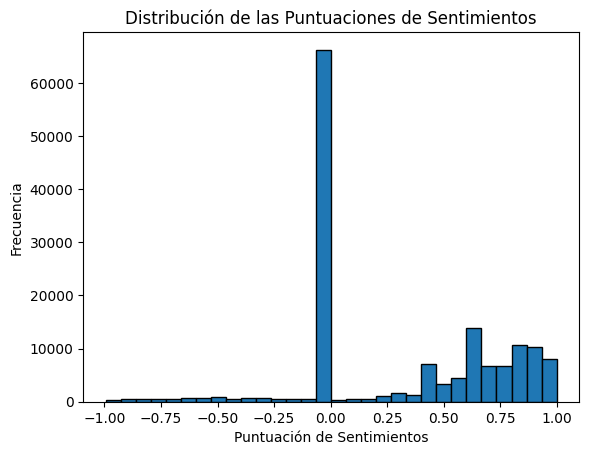

In [3]:
# Inicializar el analizador de sentimientos VADER
analyzer = SentimentIntensityAnalyzer()

# Definir una función para calcular la puntuación de sentimientos
def analizar_sentimiento(texto):
    if texto is None:
        texto = ""  # Reemplazar valores nulos con cadena vacía
    sentimientos = analyzer.polarity_scores(texto)
    return sentimientos['compound']

# Aplicar la función a la columna 'text' para obtener la puntuación de sentimientos
df['sentimiento'] = df['text'].apply(analizar_sentimiento)

# Mostrar las primeras filas del DataFrame con la nueva columna 'sentimiento'
print(df.head())

# Visualización de los resultados
# Mostrar la distribución de las puntuaciones de sentimientos
plt.hist(df['sentimiento'], bins=30, edgecolor='black')
plt.title('Distribución de las Puntuaciones de Sentimientos')
plt.xlabel('Puntuación de Sentimientos')
plt.ylabel('Frecuencia')
plt.show()


In [4]:
# Asegurarse de que la columna 'date' esté en formato de fecha
df['date'] = pd.to_datetime(df['date'])

# Extraer año y trimestre
df['año_trimestre'] = df['date'].dt.to_period('Q')

# Filtrar datos para tiendas Pizza Hut
df_pizzahut = df[df['business_name'].str.contains('Pizza Hut', case=False, na=False)]

# Agrupar por 'business_name' y 'año_trimestre' y calcular las métricas
agrupado = df_pizzahut.groupby(['business_name', 'año_trimestre']).agg(
    total_comentarios=('sentimiento', 'size'),
    comentarios_positivos=('sentimiento', lambda x: (x > 0).sum()),
    comentarios_negativos=('sentimiento', lambda x: (x < 0).sum())
).reset_index()

# Calcular la proporción de comentarios positivos respecto a negativos
agrupado['proporcion_positivos_vs_negativos'] = agrupado['comentarios_positivos'] / agrupado['comentarios_negativos']

# Mostrar las primeras filas del DataFrame resultante
print(agrupado.head())


  business_name año_trimestre  total_comentarios  comentarios_positivos  \
0     Pizza Hut        2011Q1                  4                      0   
1     Pizza Hut        2011Q2                  1                      0   
2     Pizza Hut        2011Q3                  1                      0   
3     Pizza Hut        2012Q1                  2                      0   
4     Pizza Hut        2012Q2                  1                      0   

   comentarios_negativos  proporcion_positivos_vs_negativos  
0                      0                                NaN  
1                      0                                NaN  
2                      0                                NaN  
3                      0                                NaN  
4                      1                                0.0  


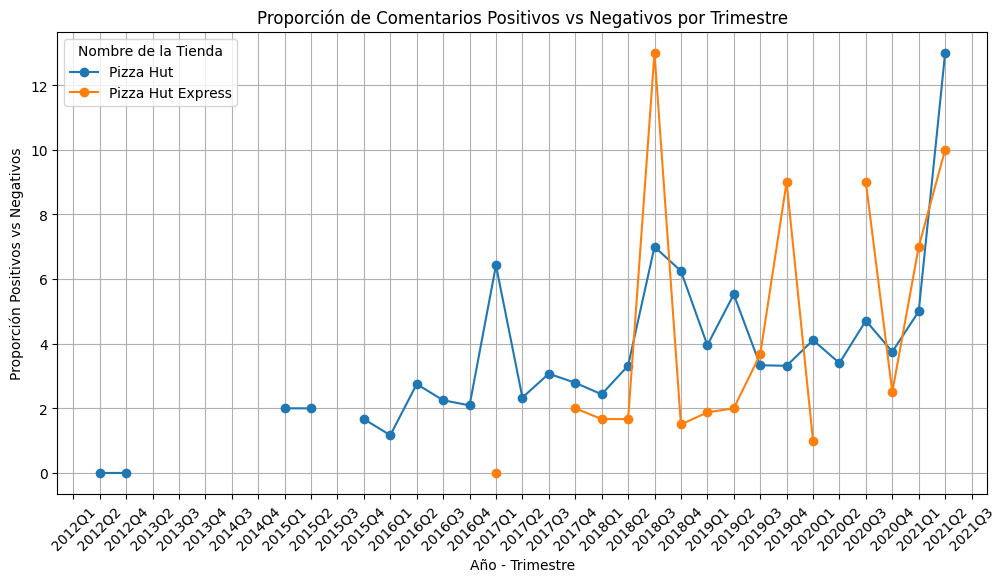

In [5]:
# Configurar la figura y los ejes
fig, ax = plt.subplots(figsize=(12, 6))

# Graficar cada tienda Pizza Hut por separado
for nombre_tienda, data in agrupado.groupby('business_name'):
    ax.plot(data['año_trimestre'].astype(str), data['proporcion_positivos_vs_negativos'], marker='o', label=nombre_tienda)

# Agregar título y etiquetas
ax.set_title('Proporción de Comentarios Positivos vs Negativos por Trimestre')
ax.set_xlabel('Año - Trimestre')
ax.set_ylabel('Proporción Positivos vs Negativos')
ax.legend(title='Nombre de la Tienda')
plt.xticks(rotation=45)
plt.grid()

# Mostrar la gráfica
plt.show()


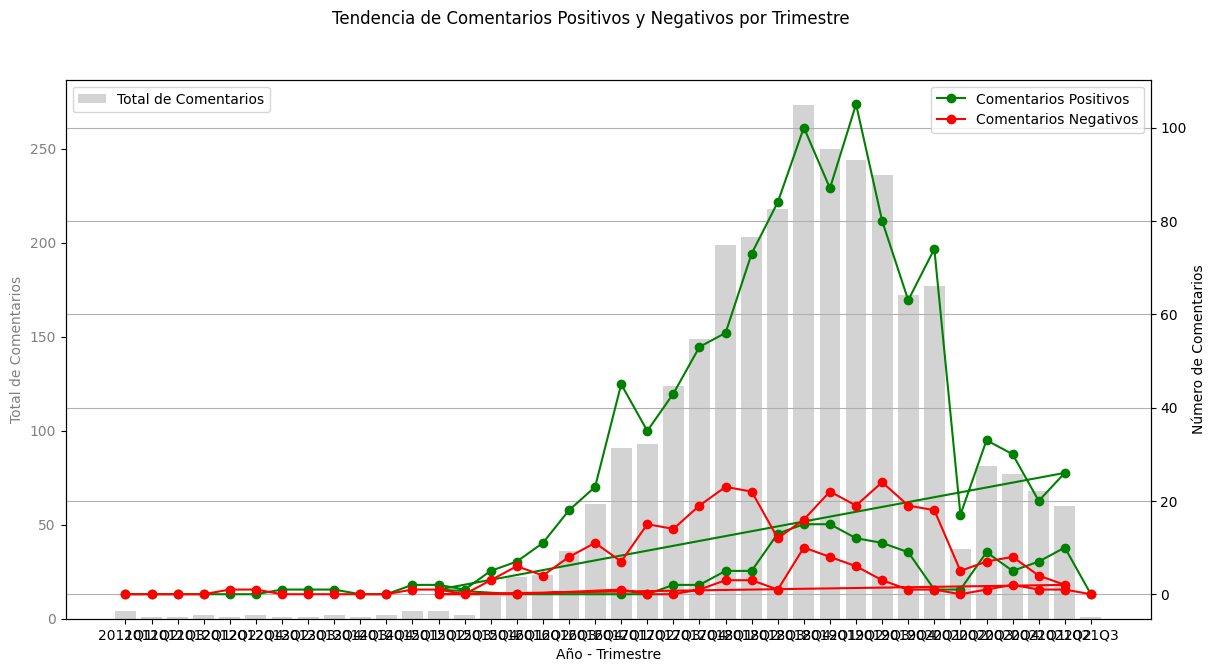

In [6]:
# Convertir 'año_trimestre' a string para facilitar la visualización
agrupado['año_trimestre'] = agrupado['año_trimestre'].astype(str)

# Configurar la figura y los ejes
fig, ax1 = plt.subplots(figsize=(14, 7))

# Gráfico de barras para el número total de comentarios por trimestre
ax1.bar(agrupado['año_trimestre'], agrupado['total_comentarios'], color='lightgray', label='Total de Comentarios')
ax1.set_xlabel('Año - Trimestre')
ax1.set_ylabel('Total de Comentarios', color='gray')
ax1.tick_params(axis='y', labelcolor='gray')

# Crear un segundo eje y
ax2 = ax1.twinx()
ax2.plot(agrupado['año_trimestre'], agrupado['comentarios_positivos'], marker='o', color='green', label='Comentarios Positivos')
ax2.plot(agrupado['año_trimestre'], agrupado['comentarios_negativos'], marker='o', color='red', label='Comentarios Negativos')
ax2.set_ylabel('Número de Comentarios', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Título y leyenda
fig.suptitle('Tendencia de Comentarios Positivos y Negativos por Trimestre')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.xticks(rotation=45)
plt.grid()
plt.show()


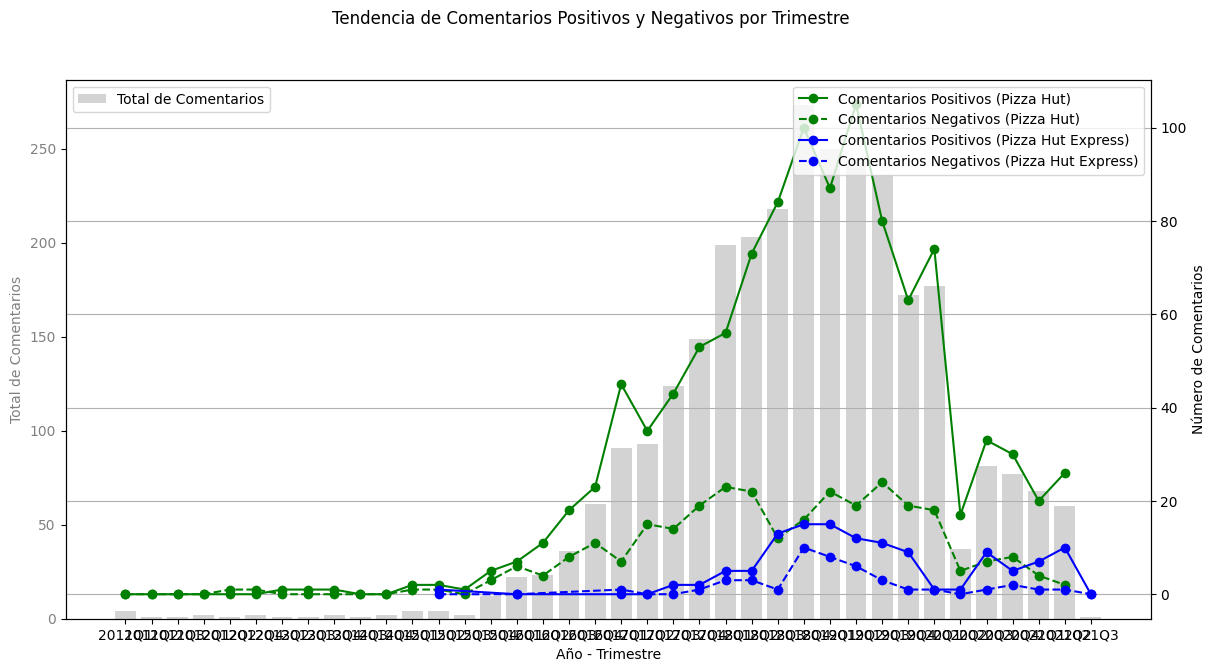

In [7]:
# Asegurarse de que la columna 'date' esté en formato de fecha
df['date'] = pd.to_datetime(df['date'])

# Extraer año y trimestre
df['año_trimestre'] = df['date'].dt.to_period('Q')

# Filtrar datos para tiendas Pizza Hut y Pizza Hut Express
df_pizzahut = df[df['business_name'].str.contains('Pizza Hut', case=False, na=False)]
df_pizzahut = df_pizzahut.assign(tipo_tienda=df_pizzahut['business_name'].apply(lambda x: 'Pizza Hut Express' if 'Express' in x else 'Pizza Hut'))

# Agrupar por 'tipo_tienda', 'business_name' y 'año_trimestre' y calcular las métricas
agrupado = df_pizzahut.groupby(['tipo_tienda', 'business_name', 'año_trimestre']).agg(
    total_comentarios=('sentimiento', 'size'),
    comentarios_positivos=('sentimiento', lambda x: (x > 0).sum()),
    comentarios_negativos=('sentimiento', lambda x: (x < 0).sum())
).reset_index()

# Calcular la proporción de comentarios positivos respecto a negativos
agrupado['proporcion_positivos_vs_negativos'] = agrupado['comentarios_positivos'] / agrupado['comentarios_negativos']

# Convertir 'año_trimestre' a string para facilitar la visualización
agrupado['año_trimestre'] = agrupado['año_trimestre'].astype(str)

# Configurar la figura y los ejes
fig, ax1 = plt.subplots(figsize=(14, 7))

# Gráfico de barras para el número total de comentarios por trimestre
ax1.bar(agrupado['año_trimestre'], agrupado['total_comentarios'], color='lightgray', label='Total de Comentarios')
ax1.set_xlabel('Año - Trimestre')
ax1.set_ylabel('Total de Comentarios', color='gray')
ax1.tick_params(axis='y', labelcolor='gray')

# Crear un segundo eje y
ax2 = ax1.twinx()

# Diferenciar entre Pizza Hut y Pizza Hut Express en las líneas de tendencia
colores = {'Pizza Hut': 'green', 'Pizza Hut Express': 'blue'}

for tipo_tienda in agrupado['tipo_tienda'].unique():
    data_tipo = agrupado[agrupado['tipo_tienda'] == tipo_tienda]
    ax2.plot(data_tipo['año_trimestre'], data_tipo['comentarios_positivos'], marker='o', label=f'Comentarios Positivos ({tipo_tienda})', color=colores[tipo_tienda])
    ax2.plot(data_tipo['año_trimestre'], data_tipo['comentarios_negativos'], marker='o', linestyle='--', label=f'Comentarios Negativos ({tipo_tienda})', color=colores[tipo_tienda])

ax2.set_ylabel('Número de Comentarios', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Título y leyenda
fig.suptitle('Tendencia de Comentarios Positivos y Negativos por Trimestre')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Rotar las etiquetas del eje X
plt.xticks(rotation=45)

plt.grid()
plt.show()
